In [119]:
import torch as pt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from matplotlib.pylab import plt
import numpy as np
from torch_optimizer import RAdam

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


torch.Size([262144, 2, 5])


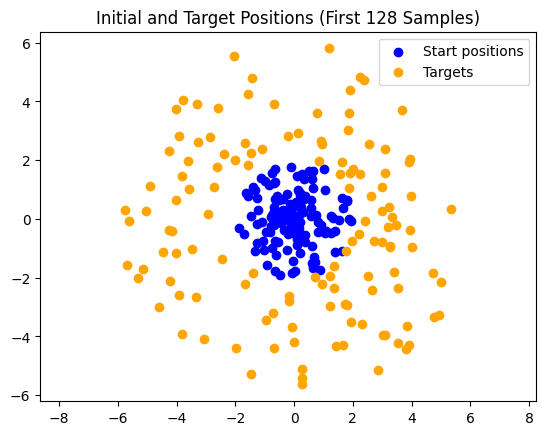

In [ ]:
def create_ics(shape=(1,)):
    _0 = pt.zeros(shape)

    def R(min=0, max=1):
        return min + (max - min) * pt.rand(shape)

    #Initial state (v0)
    # Sample a starting speed R0 E [0, 2], heading A0 E [−pi, pi]
    R0 = R(0, 2)
    A0 = R(-pt.pi, pt.pi)
    x0 = R0 * pt.cos(A0)
    y0 = R0 * pt.sin(A0)
    # Add small noise to heading
    a0 = A0 + R(-0.02, 0.02)
    s0 = R(0, 1.5)                   # speed E [0, 1.5]
    w0 = R(-0.5, 0.5)                # angular speed

    #Target state
    # Sample target radius R1 E [2, 6], angle T1 E [−pi, pi]
    R1 = R(2, 6)
    T1 = R(-pt.pi, pt.pi)
    x1 = R1 * pt.cos(T1)
    y1 = R1 * pt.sin(T1)
    # Desired heading roughly toward target, plus small noise
    base_heading = pt.atan2(y1, x1)
    a1 = base_heading + R(-pt.pi/4, pt.pi/4) + R(-0.02, 0.02)
    s1 = R(0, 1)                     # target speed E [0, 1]
    w1 = R(-0.5, 0.5)

    return pt.stack([
        pt.stack([x0, y0, a0, s0, w0], dim=-1),  # v0
        pt.stack([x1, y1, a1, s1, w1], dim=-1)   # target
    ], dim=-2)

ics = create_ics((2**18,))
print(ics.shape)

# (Optional) Quick visualization to verify spread
plt.scatter(ics[:128,0,0], ics[:128,0,1], c='blue', label='Start positions')
plt.scatter(ics[:128,1,0], ics[:128,1,1], c='orange', label='Targets')
plt.legend()
plt.axis('equal')
plt.title('Initial and Target Positions (First 128 Samples)')
plt.show()


In [121]:
def showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, wait=False, ax1_Title='Trajectory', alpha=0.5):
    if figaxs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    else:
        fig, (ax1, ax2) = figaxs

    VS = V_mat.detach().cpu().numpy() if isinstance(V_mat, pt.Tensor) else np.stack([_.detach() for _ in V_mat])
    FS = F_mat.detach().cpu().numpy()

    # lw = 2 if alpha == 1 else 0.75+alpha
    lw = 2 if alpha == 1 else 1.5

    ax1.plot(VS[:,0], VS[:,1], lw=lw, zorder=6, color='dodgerblue', alpha=alpha)

    ax2.plot(ts[:-1], FS[:,0], 'deeppink', lw=lw, alpha=alpha, label='Acceleration Force' if show and not wait else None)
    ax2.plot(ts[:-1], FS[:,1], 'limegreen', lw=lw, alpha=alpha, label='Turning Force' if show and not wait else None)


    if show:
        ax1.scatter(VS[0,0], VS[0,1], marker='*', color='sandybrown', s=200, zorder=6, alpha=alpha, label='Start' if not wait else None)
        ax1.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, alpha=alpha, label='Target' if not wait else None)
        if alpha != 0:
            ax1.scatter(VS[-1,0], VS[-1,1], marker='o', color='dodgerblue', s=60, zorder=10, alpha=alpha, label='End' if not wait else None)

        arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

        ax1.arrow(*VS[-1,0:2], *arrowDir(VS[-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3, alpha=alpha)
        ax1.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=3, zorder=2, alpha=alpha)
        ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2, alpha=alpha)
        # ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)

        if not wait:
            ax1.set_title(ax1_Title)
            ax1.set_xlabel('X Position')
            ax1.set_ylabel('Y Position')
            ax1.axis('equal')
            ax1.grid()
            ax1.legend()

            ax2.plot([0, 10], [-0.8, -0.8], '--k')
            ax2.plot([0, 10], [0.8, 0.8], '--k')
            ax2.legend()
            ax2.set_title('Forcing Terms')
            ax2.set_xlabel('Time')
            ax2.set_ylabel('Force')
            ax2.set_xlim([0, ts[-1]*1.1])
            ax2.set_ylim([-0.85, 0.85])
            ax2.grid()
            plt.show()

    return fig, (ax1, ax2)

In [122]:
def V_step(V, F):
    phi = F[...,0][:, pt.newaxis]  # linear acceleration
    psi = F[...,1][:, pt.newaxis]  # angluar acceleration
    dt = F[...,2][:, pt.newaxis]   # timestep size

    dt2 = dt*dt/2

    x = V[...,0]    # x coordinate
    y = V[...,1]    # y coordinate
    a = V[...,2]    # angle
    s = V[...,3]    # speed
    w = V[...,4]    # angular speed
    t = V[...,5]    # time

    _0 = pt.zeros_like(x, device=V.device)
    _1 = pt.ones_like(x, device=V.device)

    A1 = pt.stack([x, y, a, s, w, t], axis=-1)
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0, _0], axis=-1)
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0, _0], axis=-1)
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0, _0], axis=-1)
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0, _0], axis=-1)
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1, _0], axis=-1)
    C3 = pt.stack([_0, _0, _1, _0, _0, _0], axis=-1)
    C = dt*C2 + dt2*C3

    D = pt.stack([_0, _0, _0, _0, _0, _1], axis=-1)  # this is correct

    return A + phi*B + psi*C + dt*D

def angle_diff(theta1, theta2):
    diff = theta1 - theta2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def loss_fun(Y, T, F, scale=None):
    scale = pt.ones([1, 1, 1, 1, 1], device=Y.device)[pt.newaxis,:] if scale is None else scale
    diff = (Y[...,0:5]-T)
    diff[...,2] = angle_diff(Y[...,2], T[...,2])
    target_loss = pt.mean(pt.sum(diff * diff * scale, dim=-1))  # loss from missing the target
    time_loss = Y[...,5]                                        # loss by taking too long
    l2_loss = pt.mean(F[...,:,0:2]**2)                          # loss by using too much force
    return target_loss, time_loss, l2_loss


def compute_path_autograd(V0, F_mat, target):
    # print(f'V0 shape = {V0.shape}')
    # print(f'target shape = {target.shape}')
    # print(f'F_mat shape = {F_mat.shape}')

    V_list = [V0]   # trajectory as a list of position vectors
    for i in range(F_mat.shape[-2]):
        V_list.append(V_step(V_list[i], F_mat[...,i,:]))

    loss = loss_fun(V_list[-1], target, F_mat)

    return V_list, loss

def to_tensor(V_mat):
    batch_size = V_mat[0].shape[0]
    n_steps = len(V_mat)
    num_dims = V_mat[0].shape[-1]

    ten = pt.zeros((batch_size, n_steps, num_dims), device=V_mat[0].device)
    for i in range(n_steps):
        ten[...,i,:] = V_mat[i].detach().cpu()
    return ten[...,0:5], ten[...,5]

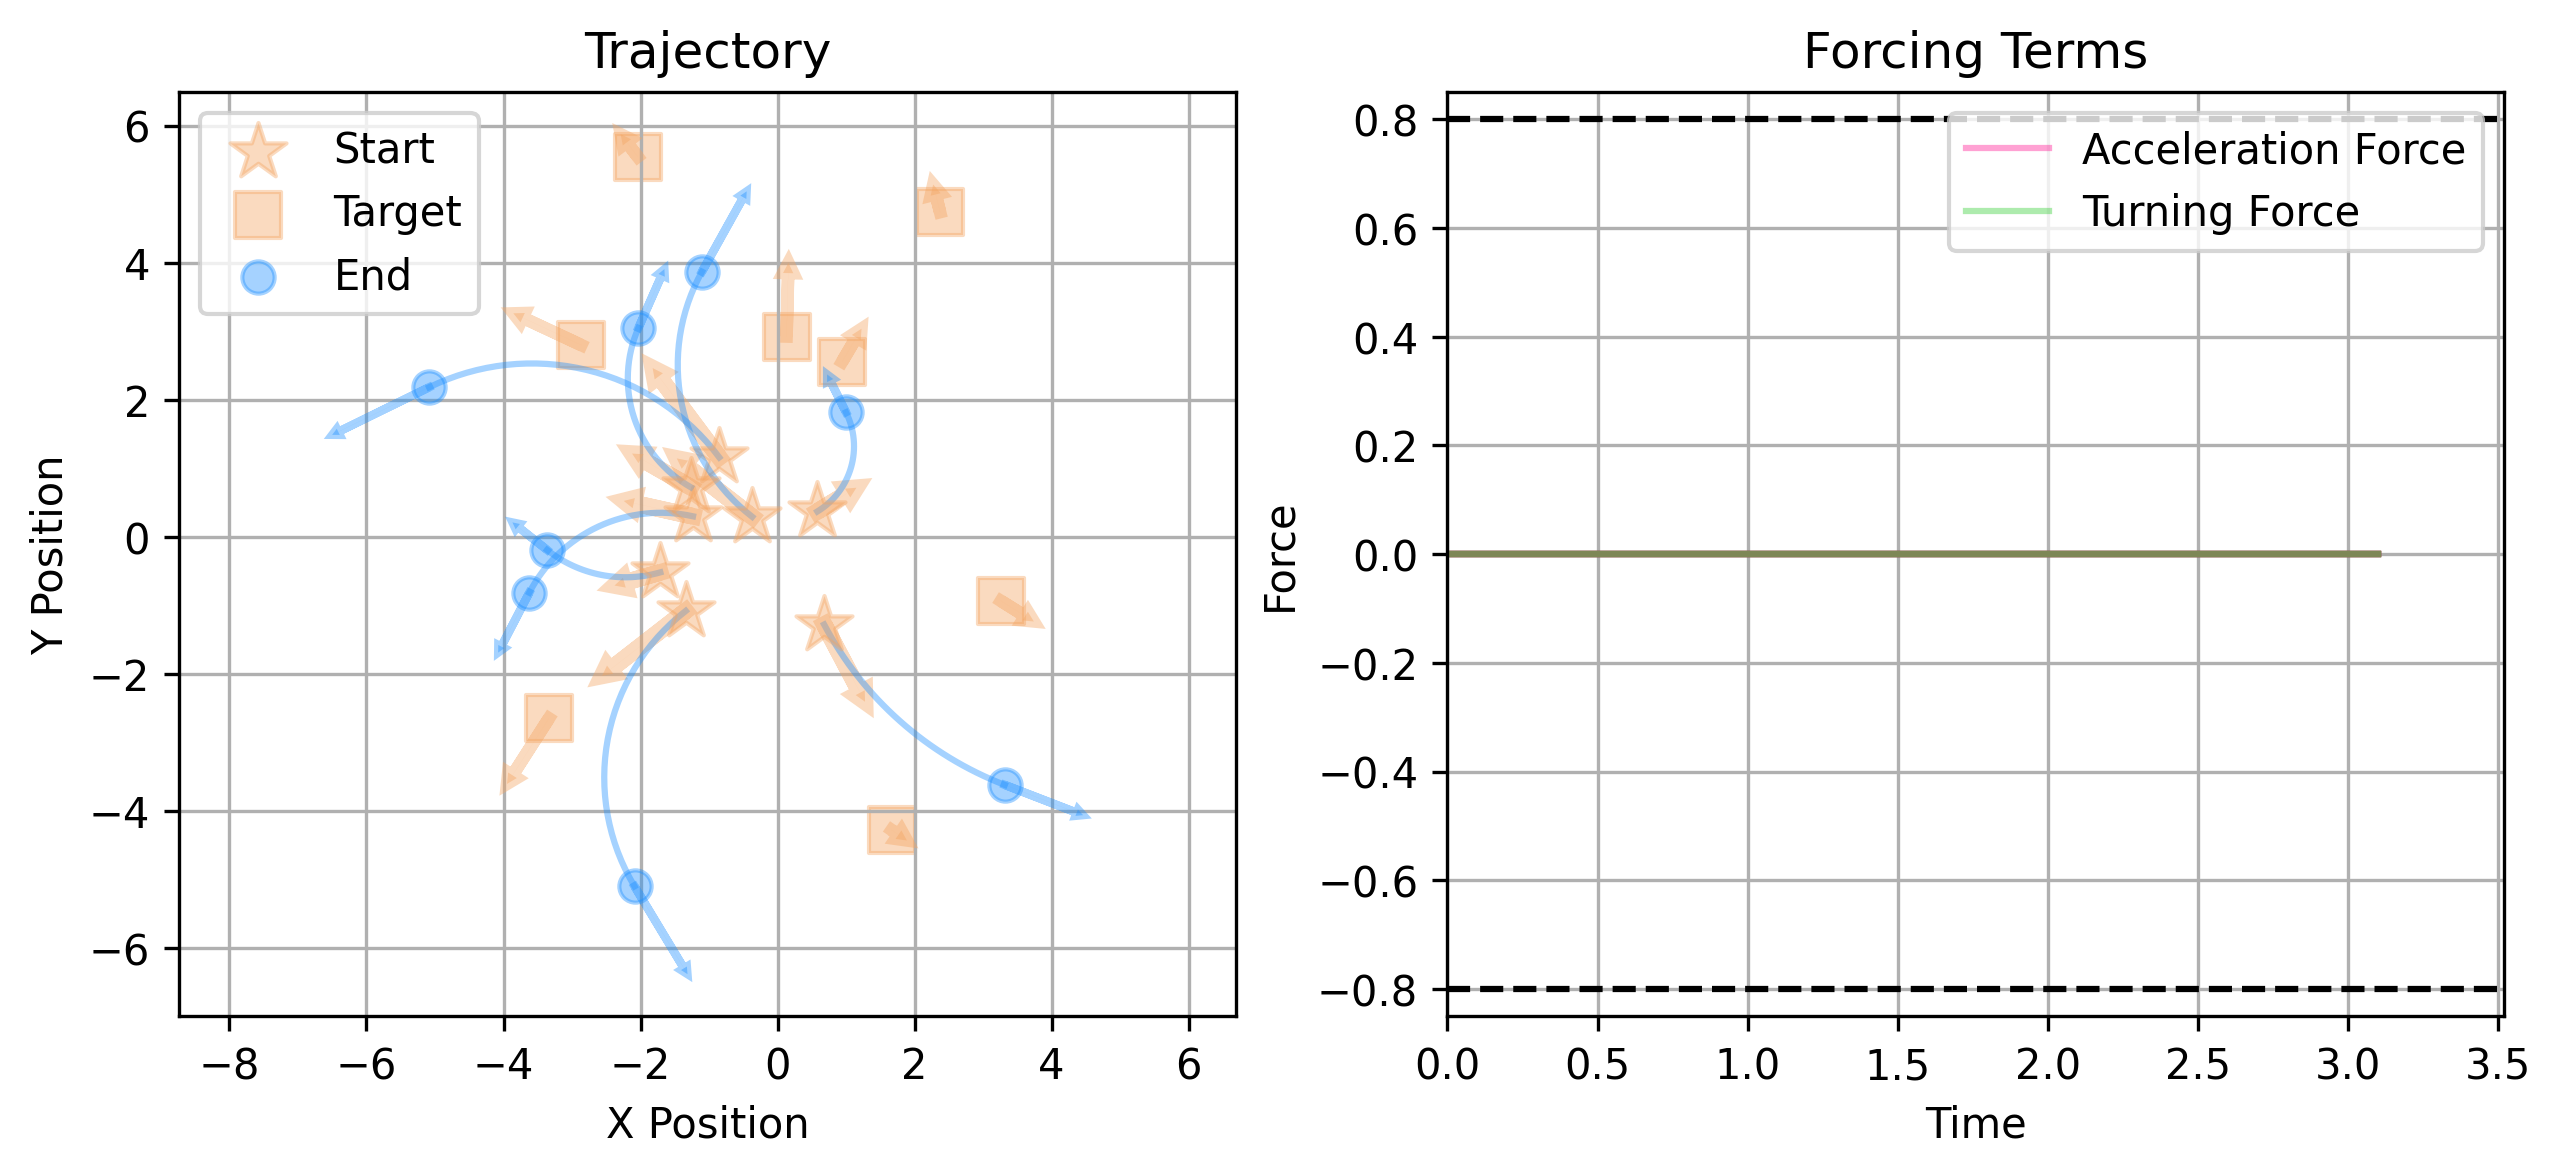

In [123]:
batch_size  =   8
n_steps     =   32

pt.cuda.empty_cache()
pt.cuda.ipc_collect()

v0 = pt.cat([ics[:batch_size,0], pt.zeros_like(ics[:batch_size,0:1,0])], dim=1).to(device)
target = ics[:batch_size,1].to(device)
F_mat = (pt.ones((batch_size, n_steps, 3)) * pt.tensor([0, 0, 0.1])[pt.newaxis, pt.newaxis, :]).to(device)

V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

traj, ts = to_tensor(V_mat)

figaxs = None
for i in range(batch_size):
    figaxs = showTraj(traj[i].cpu(), F_mat[i].cpu(), ts[i].cpu(), target[i].cpu(), figaxs=figaxs, show=True, wait=i!=batch_size-1, alpha=0.4)

In [ ]:
class ICSDataset(Dataset):
    def __init__(self, data):
        """
        data shape: (N, 2, 5), where data[:,0] = initial state (x0,y0,a0,s0,w0)
                         data[:,1] = target state  (x1,y1,a1,s1,w1)
        """
        self.data = data
        self.len = data.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Extract the raw 5‐element vectors
        v0_raw = self.data[idx, 0]    # shape (5,)
        target = self.data[idx, 1]    # shape (5,)

        # Append a zero time component to v0 to shape (6,)
        # If you’d rather keep time stacked at the end, you can do torch.cat([v0_raw, torch.zeros(1)])
        v0 = pt.cat([v0_raw, pt.zeros(1, device=v0_raw.device)])  

        return v0, target

# Usage:
total_len = min(len(ics), 2**18)
dataset = ICSDataset(ics[:total_len])
train_len = int(0.7 * total_len)
val_len   = int(0.15 * total_len)
test_len  = total_len - train_len - val_len

print(f'Train: {train_len}, Val: {val_len}, Test: {test_len}')

train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])


Train: 183500, Val: 39321, Test: 39323


In [125]:
# simple mlp
class MLP(nn.Module):
    def __init__(self, input_dim=5, output_dim=32, latent_dim=32, device=device):
        super(MLP, self).__init__()

        self.encode = nn.Sequential(
            nn.Flatten(),                                               # (b, 2, 5) -> (b, 10)
            nn.Linear(input_dim*2, latent_dim),                         # layer 1
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),                          # layer 2
            nn.ReLU(),
            nn.Linear(latent_dim, output_dim*3),                        # layer 3
            nn.Unflatten(dim=1, unflattened_size=(output_dim, 3))       # (b, 32, 3)
        )
        self.decode = nn.Sigmoid()

        self.register_buffer('limits', pt.tensor([[-0.8, -0.8, 0.01], [0.8, 0.8, 0.25]]).unsqueeze(0))

    def normalize(self, logits):
        mins = self.limits[0:1, 0:1]
        maxes = self.limits[0:1, 1:2]
        return nn.functional.sigmoid(logits) * (maxes - mins) + mins

    def forward(self, v0, target):
        ics = pt.stack([v0[...,:-1], target], dim=-2)
        logits = self.encode(ics)
        F_mat = self.normalize(logits)
        return F_mat
    
    def predict_logits(self, v0, target):
        ics = pt.stack([v0[...,:-1], target], dim=-2)
        logits = self.layers(ics)
        return logits

class MLP(nn.Module):
    def __init__(self, input_dim=5, output_dim=32, latent_dim=32, device=device):
        super(MLP, self).__init__()

        self.encode = nn.Sequential(
            nn.Flatten(),                                               # (b, 2, 5) -> (b, 10)
            nn.Linear(input_dim*2, latent_dim),                         # layer 1
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),                          # layer 2
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim),                          # layer 3
            nn.ReLU(),
            nn.Linear(latent_dim, output_dim*3),                        # layer 4
            nn.Unflatten(dim=1, unflattened_size=(output_dim, 3))       # (b, 32, 3)
        )
        self.decode = nn.Sigmoid()

        self.register_buffer('limits', pt.tensor([[-0.8, -0.8, 0.01], [0.8, 0.8, 0.25]]).unsqueeze(0))

    def normalize(self, logits):
        mins = self.limits[0:1, 0:1]
        maxes = self.limits[0:1, 1:2]
        return nn.functional.sigmoid(logits) * (maxes - mins) + mins

    def forward(self, v0, target):
        ics = pt.stack([v0[...,:-1], target], dim=-2)
        logits = self.encode(ics)
        F_mat = self.normalize(logits)
        return F_mat
    
    def predict_logits(self, v0, target):
        ics = pt.stack([v0[...,:-1], target], dim=-2)
        logits = self.layers(ics)
        return logits

In [126]:
LR              = 6e-3
WEIGHT_DECAY    = 3e-1
BATCH_SIZE      = 4096
NUM_EPOCHS      = 50

train_loader0 = DataLoader(train_set, batch_size=BATCH_SIZE//4, shuffle=True)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2048, shuffle=False)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False)

mlp = MLP(latent_dim=64).to(device)

optimizer = pt.optim.AdamW(mlp.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

losses = []
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    mlp.train()
    train_loss = 0.0
    val_loss = 0.0

    # Train
    for batch, (v0, target) in enumerate(train_loader0 if epoch < 5 else train_loader):
        v0, target = v0.to(device), target.to(device)

        # Foward
        F_mat = mlp(v0, target)
        V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

        # Backward
        optimizer.zero_grad()

        unsmooth_loss = pt.mean((F_mat[...,2:] + F_mat[...,:-2] - 2 * F_mat[...,1:-1])**2)
        loss = target_loss + 5e0 * l2_loss + 5e-1 * unsmooth_loss
        loss.backward()
        optimizer.step()

        with pt.no_grad():
            train_loss += pt.mean(target_loss)
    train_avg = train_loss / len(train_loader)

    # Val
    with pt.no_grad():
        for batch, (v0, target) in enumerate(train_loader):
            v0, target = v0.to(device), target.to(device)

            # Foward
            F_mat = mlp(v0, target)
            V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)

            val_loss += pt.mean(target_loss)
    val_avg = val_loss / len(val_loader)

    losses.append([train_avg, val_avg])
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_avg:.4f}, Val Loss: {val_avg:.4f}")



Epoch 1/50, Train Loss: 75.9895, Val Loss: 6.0406
Epoch 2/50, Train Loss: 6.4194, Val Loss: 3.6064
Epoch 3/50, Train Loss: 4.6308, Val Loss: 2.1116
Epoch 4/50, Train Loss: 4.0184, Val Loss: 2.2148
Epoch 5/50, Train Loss: 3.9123, Val Loss: 2.0507
Epoch 6/50, Train Loss: 0.8683, Val Loss: 2.3207
Epoch 7/50, Train Loss: 0.8687, Val Loss: 2.8246
Epoch 8/50, Train Loss: 0.9199, Val Loss: 1.8787
Epoch 9/50, Train Loss: 0.9183, Val Loss: 2.3392
Epoch 10/50, Train Loss: 0.8714, Val Loss: 1.6712
Epoch 11/50, Train Loss: 1.0554, Val Loss: 1.8591
Epoch 12/50, Train Loss: 0.8571, Val Loss: 2.8678
Epoch 13/50, Train Loss: 0.8521, Val Loss: 2.1713
Epoch 14/50, Train Loss: 0.8803, Val Loss: 1.6754
Epoch 15/50, Train Loss: 0.9216, Val Loss: 1.7665
Epoch 16/50, Train Loss: 0.8711, Val Loss: 1.6821
Epoch 17/50, Train Loss: 0.9266, Val Loss: 1.6396
Epoch 18/50, Train Loss: 0.8613, Val Loss: 1.7946
Epoch 19/50, Train Loss: 0.8649, Val Loss: 2.0905
Epoch 20/50, Train Loss: 0.9820, Val Loss: 2.2197
Epoch 21

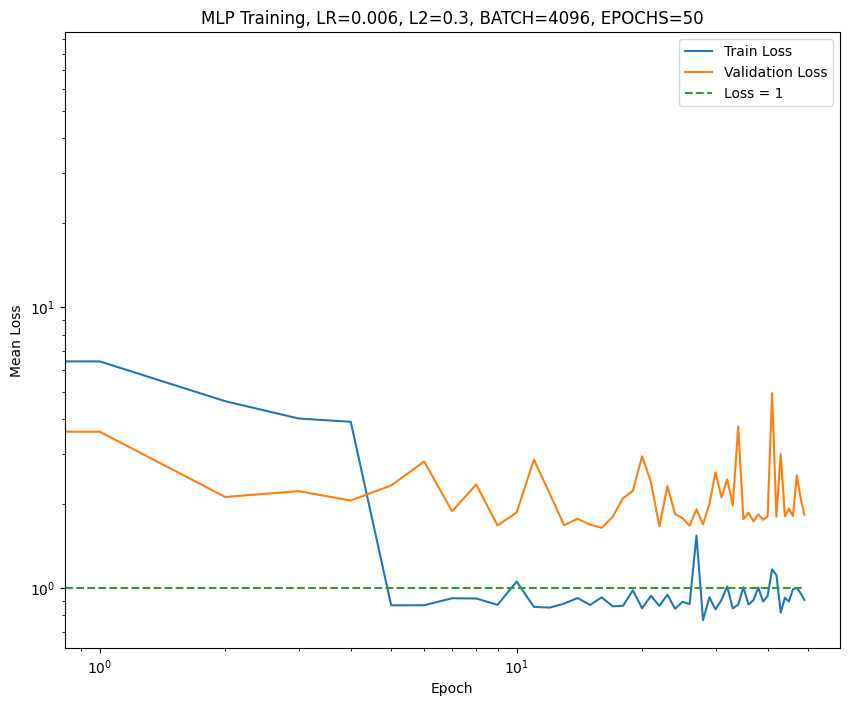

In [127]:
losses_np = pt.tensor(losses).cpu().numpy()
plt.figure(figsize=(10,8))
plt.plot(losses_np)
plt.plot(losses_np[...,0]*0+1, '--')
plt.title(f'MLP Training, LR={LR}, L2={WEIGHT_DECAY}, BATCH={BATCH_SIZE}, EPOCHS={NUM_EPOCHS}')
plt.legend(['Train Loss', 'Validation Loss', 'Loss = 1'])
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.xscale('log')
plt.yscale('log')
plt.show()

Target Loss = 4.114834785461426


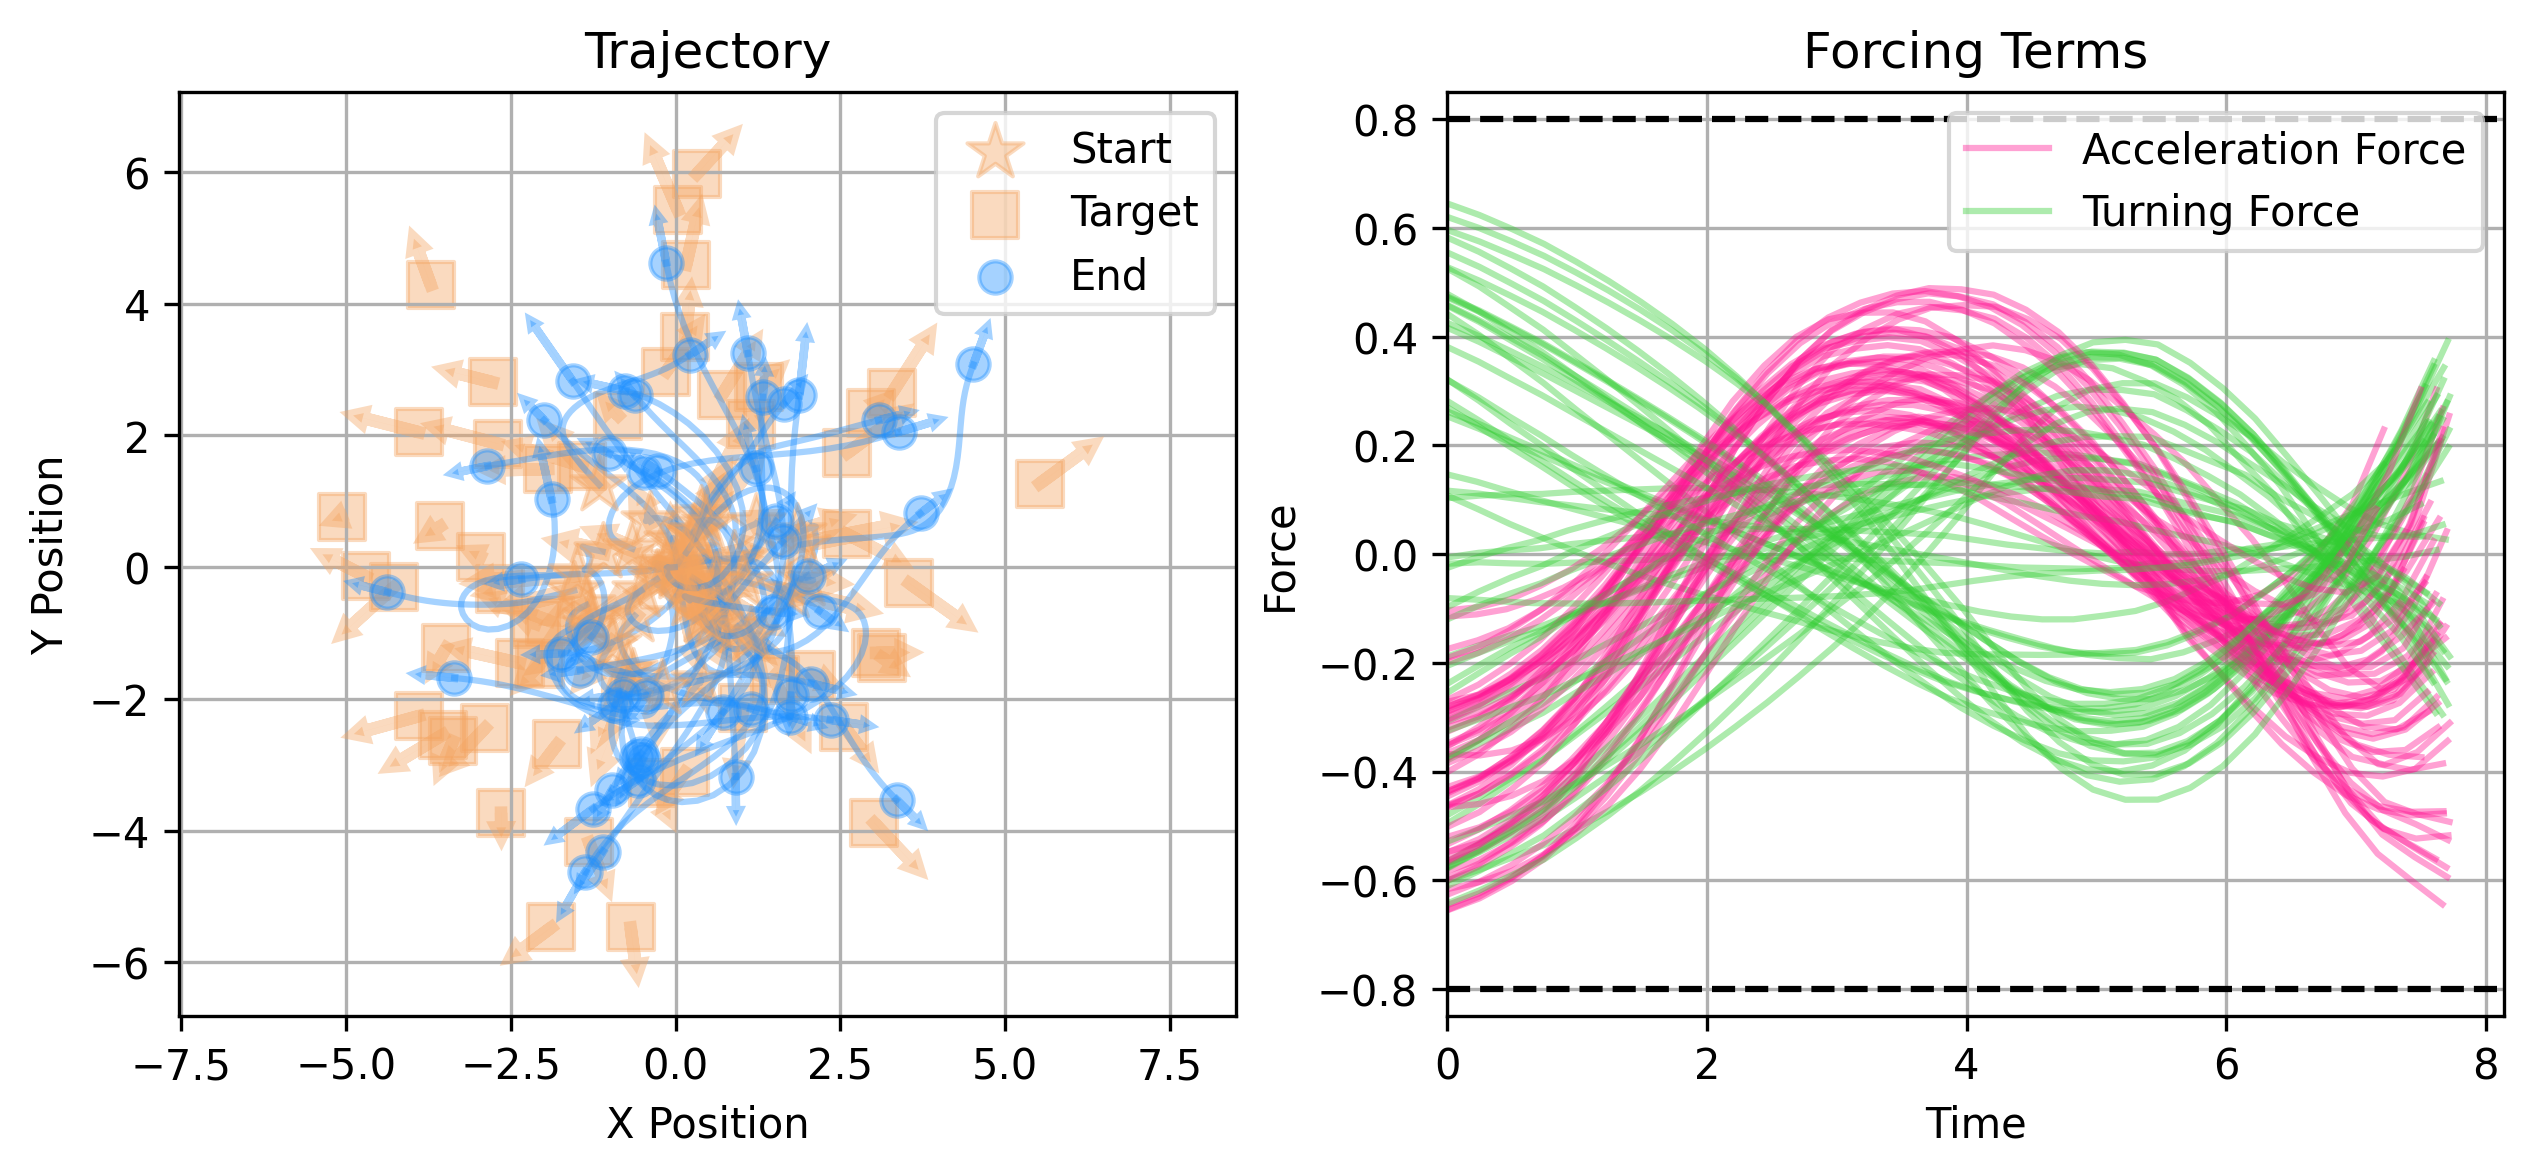

tensor([[-0.5827,  0.5550,  0.2473],
        [-0.5621,  0.5285,  0.2484],
        [-0.5312,  0.4976,  0.2464],
        [-0.4909,  0.4659,  0.2467],
        [-0.4394,  0.4297,  0.2462],
        [-0.3738,  0.3925,  0.2458],
        [-0.2935,  0.3538,  0.2450],
        [-0.2023,  0.3136,  0.2447],
        [-0.1042,  0.2715,  0.2453],
        [-0.0064,  0.2266,  0.2465],
        [ 0.0804,  0.1785,  0.2470],
        [ 0.1565,  0.1269,  0.2486],
        [ 0.2144,  0.0721,  0.2493],
        [ 0.2521,  0.0150,  0.2491],
        [ 0.2775, -0.0444,  0.2494],
        [ 0.2878, -0.1045,  0.2496],
        [ 0.2774, -0.1640,  0.2494],
        [ 0.2571, -0.2241,  0.2497],
        [ 0.2179, -0.2790,  0.2497],
        [ 0.1698, -0.3229,  0.2496],
        [ 0.1129, -0.3530,  0.2496],
        [ 0.0507, -0.3667,  0.2494],
        [-0.0091, -0.3653,  0.2495],
        [-0.0651, -0.3439,  0.2495],
        [-0.1200, -0.3064,  0.2492],
        [-0.1659, -0.2524,  0.2492],
        [-0.2017, -0.1835,  0.2491],
 

In [153]:
batch_size  =   50


with pt.no_grad():
    v0, target = next(iter(train_loader))
    v0, target = v0.to(device), target.to(device)

    # Foward
    F_mat = mlp(v0, target)
    V_mat, (target_loss, time_loss, l2_loss) = compute_path_autograd(v0, F_mat, target)


print(f'Target Loss = {target_loss}')
traj, ts = to_tensor(V_mat)

figaxs = None
for i in range(batch_size):
    figaxs = showTraj(traj[i].cpu(), F_mat[i].cpu(), ts[i].cpu(), target[i].cpu(), figaxs=figaxs, show=True, wait=i!=batch_size-1, alpha=0.4)

print(F_mat[0])

In [ ]:
#RNNRefiner
class RNNRefiner(nn.Module):
    def __init__(self, mlp, hidden_size=256, num_layers=4, device='cuda'):
        super().__init__()
        self.mlp = mlp
        for p in self.mlp.parameters():
            p.requires_grad = True
        self.device = device

        # Since bidirectional=True, each layer’s internal hidden size is hidden_size//2
        lstm_hidden = hidden_size // 2
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            input_dim = 3 if i == 0 else hidden_size
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=input_dim,
                    hidden_size=lstm_hidden,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=True,
                    dropout=0.2
                )
            )

        self.fc = nn.Linear(hidden_size, 3) #maps bi-LSTM feats to deltaF

    def forward(self, v0, target):
        baseline_F = self.mlp(v0, target)  # pretrained mlp | shape = (batch, T, 3)
        x = baseline_F.to(self.device) #feed baseline through 4xBi-LSTM 
        for i, lstm in enumerate(self.lstm_layers): 
            out, _ = lstm(x)
            if out.shape == x.shape:
                x = out + x
            else:
                x = out

        delta = self.fc(x)#predict delta F via a small FC head, (batch, T, 3)

        F_refined = baseline_F + delta #add residual to baseline controls 
        return F_refined #final (batch, 32, 3)

In [ ]:
# 3) Instantiate model and optimizer with separate LRs
 
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

#mlp is pretrained MLP 
rnn_refiner = RNNRefiner(mlp=mlp, hidden_size=256, num_layers=4, device=device).to(device)

# Separate param, small LR for MLP, larger for RNN+FC
mlp_params = list(rnn_refiner.mlp.parameters())
rnn_params = [p for n, p in rnn_refiner.named_parameters() if not n.startswith('mlp.')]

optimizer = RAdam([
    {'params': mlp_params, 'lr': 5e-5},   # very small LR for MLP fine-tuning #learning rate to avoid gradient explosion    
    {'params': rnn_params, 'lr': 5e-4}    # train RNN +FC faster
], weight_decay = 1e-6)

# Cosine annealing scheduler (no warm-up)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

In [ ]:

NUM_EPOCHS = 100
rnn_train_losses = []
rnn_val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    # adjust dropout on later epochs
    for lstm in rnn_refiner.lstm_layers:
        lstm.dropout = min(0.2, epoch / NUM_EPOCHS * 0.3)

    # Training phase 
    rnn_refiner.train()
    running_train = 0.0


    for v0_batch, target_batch in train_loader:
        v0_batch = v0_batch.to(device)
        target_batch = target_batch.to(device)

        # Augment ICs with small noise
        v0_batch[..., 0:2] += pt.randn_like(v0_batch[..., 0:2]) * 0.01  # position noise
        v0_batch[..., 2]   += pt.randn_like(v0_batch[..., 2]) * 0.02    # heading noise

        # Forward pass (joint MLP + RNN)
        F_refined = rnn_refiner(v0_batch, target_batch)

        # Compute trajectory and losses
        V_list, (t_loss, time_loss, l2_loss) = compute_path_autograd(
            v0_batch, F_refined, target_batch
        )
        # Smoothness penalty (finite differences on deltaF)
        unsmooth = pt.mean(
            (F_refined[..., 2:] + F_refined[..., :-2] - 2 * F_refined[..., 1:-1]) ** 2
        )

        # Multi-horizon loss at halfway point
        half_horizon = F_refined.shape[1] // 2
        half_loss = compute_path_autograd(v0_batch, F_refined[:, :half_horizon], target_batch)[1][0]
        loss = 1.0 * half_loss + 1.0 * t_loss + 0.5 * l2_loss + 0.1 * unsmooth

        # Weighted total loss
        loss = t_loss + 0.5 * l2_loss + 0.1 * unsmooth

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to stabilize training
        pt.nn.utils.clip_grad_norm_(rnn_refiner.parameters(), max_norm=2.0)

        optimizer.step()
        running_train += loss.item()

    avg_train = running_train / len(train_loader)
    rnn_train_losses.append(avg_train)

    #Validation phase 
    rnn_refiner.eval()
    running_val = 0.0
    with pt.no_grad():
        for v0_batch, target_batch in val_loader:
            v0_batch = v0_batch.to(device)
            target_batch = target_batch.to(device)

            F_refined = rnn_refiner(v0_batch, target_batch)
            _, (t_loss, *_ ) = compute_path_autograd(v0_batch, F_refined, target_batch)
            running_val += t_loss.item()

    avg_val = running_val / len(val_loader)
    rnn_val_losses.append(avg_val)

    print(f"Epoch {epoch}/{NUM_EPOCHS} — Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

    # Step the LR scheduler
    scheduler.step()

Epoch 1/100 — Train Loss: 5.2367, Val Loss: 0.9848
Epoch 2/100 — Train Loss: 0.8704, Val Loss: 0.7566
Epoch 3/100 — Train Loss: 0.8073, Val Loss: 0.7230
Epoch 4/100 — Train Loss: 0.7838, Val Loss: 0.7054
Epoch 5/100 — Train Loss: 0.7676, Val Loss: 0.6927
Epoch 6/100 — Train Loss: 0.7557, Val Loss: 0.6834
Epoch 7/100 — Train Loss: 0.7461, Val Loss: 0.6723
Epoch 8/100 — Train Loss: 0.7379, Val Loss: 0.6667
Epoch 9/100 — Train Loss: 0.7315, Val Loss: 0.6595
Epoch 10/100 — Train Loss: 0.7309, Val Loss: 0.6759
Epoch 11/100 — Train Loss: 0.7272, Val Loss: 0.6524
Epoch 12/100 — Train Loss: 0.7237, Val Loss: 0.6618
Epoch 13/100 — Train Loss: 0.7114, Val Loss: 0.6410
Epoch 14/100 — Train Loss: 0.7078, Val Loss: 0.6536
Epoch 15/100 — Train Loss: 0.7051, Val Loss: 0.6352
Epoch 16/100 — Train Loss: 0.6985, Val Loss: 0.6259
Epoch 17/100 — Train Loss: 0.6965, Val Loss: 0.6361
Epoch 18/100 — Train Loss: 0.6986, Val Loss: 0.6459
Epoch 19/100 — Train Loss: 0.6922, Val Loss: 0.6169
Epoch 20/100 — Train 

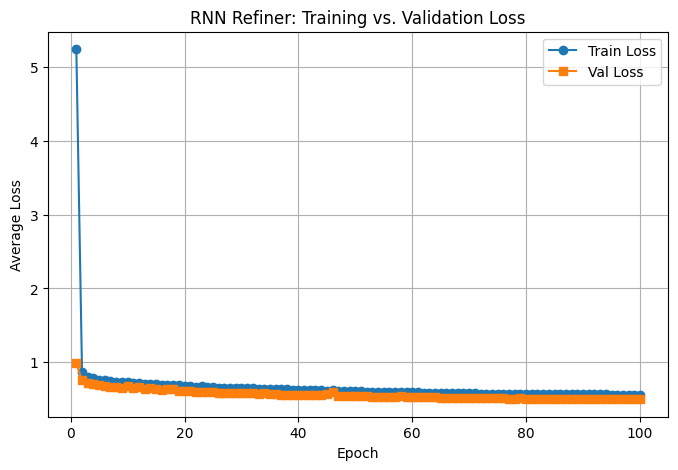

In [132]:
# —— Plot the curves —— 
plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), rnn_train_losses, marker='o', label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), rnn_val_losses,   marker='s', label='Val Loss')
plt.title('RNN Refiner: Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

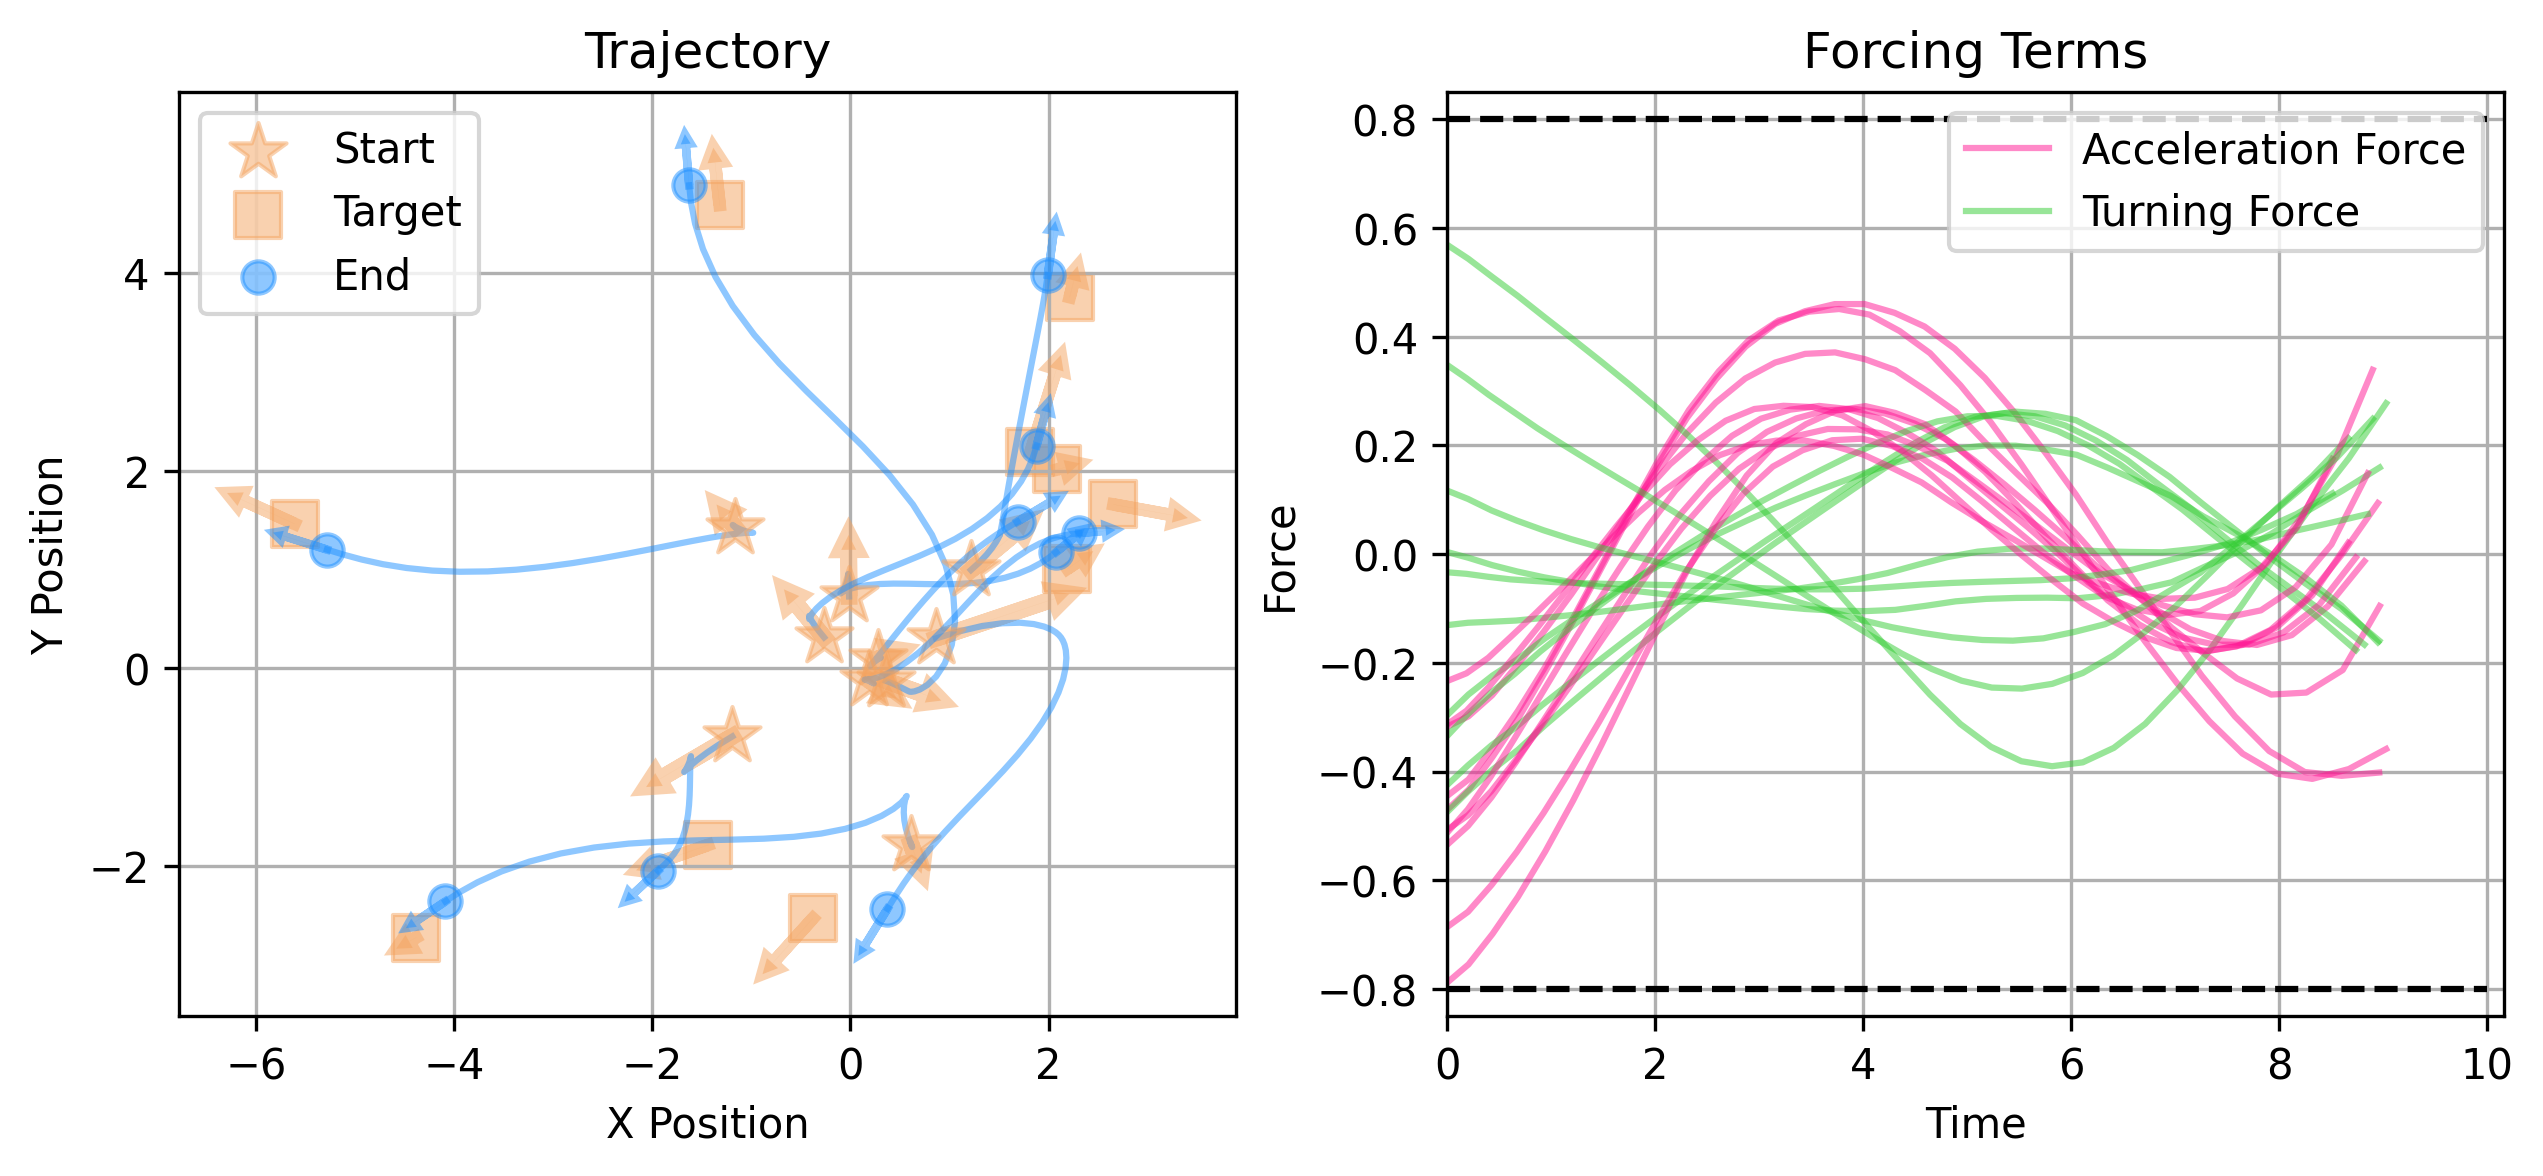

In [160]:
# ------------------------------------------------------------
# 4) Visualize a few refined trajectories
# ------------------------------------------------------------
import matplotlib.pyplot as plt

rnn_refiner.eval()
with pt.no_grad():
    v0_sample, target_sample = next(iter(val_loader))  
    v0_sample = v0_sample.to(device)
    target_sample = target_sample.to(device)

    F_ref = rnn_refiner(v0_sample, target_sample)
    V_list, _ = compute_path_autograd(v0_sample, F_ref, target_sample)
    traj, ts = to_tensor(V_list)

# plot first 4
figax = None
for i in range(min(10, traj.shape[0])):
    figax = showTraj(
        traj[i].cpu(), 
        F_ref[i].cpu(), 
        ts[i].cpu(), 
        target_sample[i].cpu(),
        figaxs=figax,
        alpha=0.5,
        show=True,
        wait=(i != min(10, traj.shape[0]) - 1)
    )

In [148]:
rnn_refiner.eval()
val_loss = 0.0
with pt.no_grad():
    for v0, target in val_loader:
        v0, target = v0.to(device), target.to(device)
        F_refined = rnn_refiner(v0, target)
        V_mat, (t_loss, *_ ) = compute_path_autograd(v0, F_refined, target)
        val_loss += t_loss.item()
avg_val = val_loss / len(val_loader)
print(f"Val Loss: {avg_val:.4f}")


Val Loss: 0.5014
